In [1]:
import pandas as pd
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.float_format', '{:,.4g}'.format)
np.set_printoptions(precision=4, edgeitems=10, linewidth=180, suppress=True)

**Введённые понятия**
- Сито разделено нитями на т.н. *полосы* вдоль каждой из двух осей - X и Y, каждая полоса имеет номер в пределах **от 0 до m-1**.
- Номер ячейки - пара номеров полос по обеим осям, например: `(12, 7)`.
- Относительные координаты - связаны с начальным положением частицы; начало координат - левый нижний угол частицы, оси совпадют с её гранями.
- Абсолютные координаты - связаны с ситом; начало координат - левый нижний угол ячейки под номером `(0, 0)`
- "Активная" ячейка - та, в которую попала хотя бы одна вершина.

Константы

In [2]:
D = 10  # Размер  сита
m = 20  # Число ячеек
a = D / m  # Ширина ячейки
b, k = 0.4, 0.1  # Наибольший размер частицы, соотношение сторон

Нахождение соcтояния частицы после "встряхивания"

In [3]:
def initialize_state(b=b, k=k, D=D, angle=0):
    '''
    alpha - угол поворота
    '''
    # Начальные координаты
    X0 = np.random.uniform(0, D - b, size=(2, 1))

    # Относительные координаты 4 характрерных вершин
    N0 = np.array([[0, b,  0 ,  b ],
                   [0, 0, k*b, k*b]])

    # Матрица поворота
    rotation_matrix = np.array([[cos(angle), -sin(angle)],
                                [sin(angle),  cos(angle)]])
    
    # Относительные координаты после вращения
    N1 = rotation_matrix @ N0

    # Положение вершин после вращения
    X1 = X0 + N1
    return X1

Проходит ли частица сквозь сито. Возможны 3 ситуации:
- 0 - не проходит
- 1 - проходит
- 2 - балансирует на нитях, нужен расчёт

In [4]:
def is_passing(state, a=a):
    # Координаты полос, куда проецируются вершины
    cells_coordinates = (state // a).astype(int)

    # Если частица "цепляет" три параллельных полосы (т.е задевает две параллельные нити)
    # => она не прохоит сквозь сито.
    if any((cells_coordinates.max(axis=1) - cells_coordinates.min(axis=1)) >= 2):
        return 0
    
    # Нахождение номеров активных ячеек
    cells_numbers = np.dstack((state[:2] // a).astype(int)).reshape(4, 2)

    # Список активных ячеек и число входящих в них вершин
    unique_cells, entries_count = np.unique(cells_numbers, axis=0, return_counts=True)

    # Вершины попали в 4 разных ячейки "квадратом"
    if len(unique_cells) ==  4:
        return 0
    
    # Вершины попали в две ячейки
    if len(unique_cells) <= 2:
        # Активные вершины расположены "наискосок"
        if all(cells_numbers.max(axis=0) != cells_numbers.min(axis=0)):
            return 2
        
        # В других случаях - проходит
        return 1
    
    # Активны три ячейки "не в ряд" - частица балансирует
    return 2

In [5]:
A = np.random.randint(5, size=(2, 4))
#S = initialize_state()
#is_passing(S)
print(A)
print(A.max(axis=1), A.min(axis=1))
print(A.max(axis=1) - A.min(axis=1)>=3)


[[1 4 0 4]
 [3 4 4 1]]
[4 4] [0 1]
[ True  True]


Построение графика с частицами на сите

In [6]:
def parts_on_grid_plot(n_particles=10, a=a, b=b, k=k, D=D):
    #Строим график
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set(xlim=(0, D), ylim=(0, D))
    ax.xaxis.set_ticks([i for i in np.arange(0, D+a, a)])
    ax.yaxis.set_ticks([i for i in np.arange(0, D+a, a)])
    plt.grid()
    
    # Повторяем для каждой частицы
    passing_counter, balancing_counter = 0, 0
    for _ in range(n_particles):
        
        # Создание частицы
        alpha = np.random.uniform(0, np.pi/2)
        initial_state = initialize_state(b=b, k=k, D=D, angle=alpha)
        
        # Проходит ли частица сетку
        passing = is_passing(initial_state, a=a)
        color = 'red'
        if passing == 1:
            passing_counter += 1
            color = 'green'
        elif passing == 2:
            balancing_counter += 1
            color = 'brown'
        
        # Отрисовываем частицу
        ax.add_patch(Rectangle(initial_state[:, 0], b, k*b, np.degrees(alpha), color=color))
    
    print(f'Число прошедших сетку частиц: {passing_counter}\n'
          f'Число частиц в состоянии баланса: {balancing_counter}\n'
          f'Число задержавшихся частиц: {n_particles - passing_counter - balancing_counter}')
        

Число прошедших сетку частиц: 13
Число частиц в состоянии баланса: 29
Число задержавшихся частиц: 58


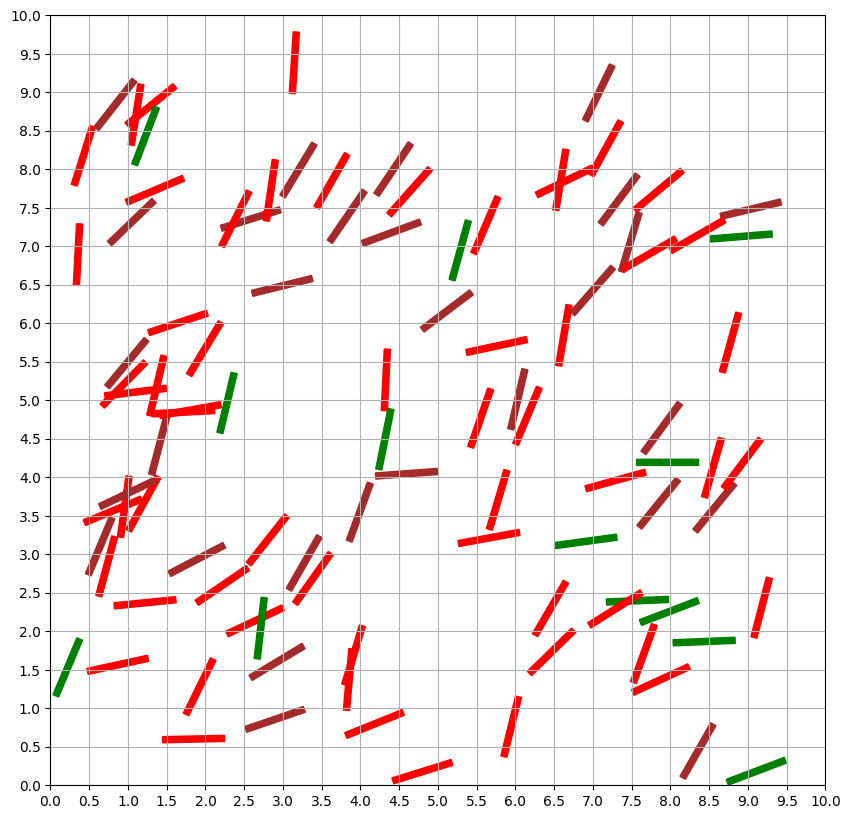

In [7]:
parts_on_grid_plot(n_particles=100, b=2*b)

Определение вероятности прохождения

In [8]:
def get_passing_probability(n_particles=10, a=a, b=b, k=k, D=D):
    # Повторяем для каждой частицы
    passing_counter, balancing_counter = 0, 0
    for _ in range(n_particles):
        
        # Создание частицы
        alpha = np.random.uniform(0, np.pi/2)
        initial_state = initialize_state(b=b, k=k, D=D, angle=alpha)
        
        # Проходит ли частица сетку
        passing = is_passing(initial_state, a=a)
        if passing == 1:
            passing_counter += 1
        elif passing == 2:
            balancing_counter += 1

    # Считаем, что среди балансирующих частиц сито проходит каждая вторая
    return (passing_counter + balancing_counter // 2) / n_particles

Проведение серии экспериментов при различных параметрах

In [9]:
def get_probability_grid(n_particles=10, b_lim=np.geomspace(0.1, 10, num=10), k_lim=np.arange(0.1, 1.1, 0.1), D=D, a=a):
    #
    prob_grid = np.zeros(shape=(len(k_lim), len(b_lim)))
    for k_num, k in enumerate(k_lim):
        for b_num, b in enumerate(a*b_lim):
            prob_grid[k_num, b_num] = get_passing_probability(n_particles=n_particles, k=k, b=b, a=a, D=D)

    # Создаём датафрейм с полученными данными
    col_names = list(map(lambda x: round(x, 2), b_lim))
    probabiliities_df = pd.DataFrame(prob_grid, index=k_lim, columns=col_names).rename_axis('k | b\\a', axis=1)
    probabiliities_df.style.format_index({0: lambda v: v}, axis=1, precision=1)
    
    return probabiliities_df
                

In [10]:
grid = get_probability_grid(n_particles=100)
grid

k | b\a,0.1,0.17,0.28,0.46,0.77,1.29,2.15,3.59,5.99,10
0.1,1,0.99,0.99,0.92,0.86,0.58,0,0,0,0
0.2,1,1,0.97,0.96,0.85,0.45,0,0,0,0
0.3,0.99,0.99,0.96,0.92,0.78,0.45,0,0,0,0
0.4,1,0.99,0.98,0.95,0.71,0.32,0,0,0,0
0.5,0.99,0.99,0.97,0.9,0.67,0.22,0,0,0,0
0.6,1,0.98,0.96,0.9,0.65,0.26,0,0,0,0
0.7,1,0.97,0.97,0.82,0.61,0.12,0,0,0,0
0.8,0.99,0.98,0.92,0.84,0.55,0.02,0,0,0,0
0.9,0.98,0.98,0.9,0.81,0.46,0.01,0,0,0,0
1,0.98,0.97,0.93,0.77,0.38,0,0,0,0,0


Графики полученного распределения

In [11]:
X, Y = np.meshgrid(grid.index, grid.columns)
fig = go.Figure(data=[go.Surface(x=X,
                   y=Y,
                   z=grid,
                   #opacity=0.5,
                  )])

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-0.1, 1.1],  title= 'k' ),
        yaxis = dict(nticks=4, range=[-0.1, 10.1], title='b/a'),
        zaxis = dict(nticks=4, range=[-0.1, 1.1],  title= 'P' )),
    width=800,
    height=800,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [12]:
X, Y = np.meshgrid(grid.index, grid.columns)

fig = px.scatter_3d(x=np.hstack(X), y=np.hstack(Y), z=np.hstack(grid.values))

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-0.1, 1.1],  title= 'k' ),
        yaxis = dict(nticks=4, range=[-0.1, 10.1], title='b/a'),
        zaxis = dict(nticks=4, range=[-0.1, 1.1],  title= 'P' )),
    width=800,
    height=800,
    margin=dict(r=20, l=10, b=10, t=10))


fig.show()